### TODO

+ scaling? bg notes
+ other model comparison
+ explicit bets and no bets
+ feature engineering
+ NN implementation
+ shap and LIME (local/global explainability)

# Predicting mixed martial art fights winners 

## Intro

Mixed martial arts (MMA) is a combat sport based on striking, grappling and ground fighting, which incorporates many different techniques from martial arts across the world. The biggest MMA organization in the USA is the Ultimate fighting Championship (UFC), publishes comprehensive statistics on fighter offensive/defensive output, fighter physiology, and outcomes of the fights. These data have been scraped from the web here [LINK]. As in all major sports, betting is a major activity amongst fans. The UFC embraces it more than most leagues, feature gambling odds during their events and promoting their partnerships sportsbooks. The gambling odds for a subset of fights are found here [Link]. The specific odds for a fight reflect the collective perception of individual gamblers, who may rely on vague prior knowledge as a fight fan, some bespoke ML model, or just a "gut feeling". Whatever the case may be, I am curious if incorporating gamlbing odds can improve the predictions of fight winners compared to previously publsished datasets on kaggle.

## The goal
Combine two datasets, one with fight gambling odds and one with individual fighter metrics. Does the addition of gambling odds improve the model predictions? Can the number of features be reduced (with feature extraction/selection) to make a simpler model? Which model type results in the highest accuracy?

Target variable = "Winner" with labels (Red,Blue) referring to the color of the Red corner or Blue corner fighter. 

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

from xgboost import XGBClassifier

In [ ]:
# non standard packages needed
#! pip install shap

## Load data: Pandas version

In [7]:
#pd.set_option('display.max_rows', 200)

In [21]:
df_bet = pd.read_csv('data-bets.csv', parse_dates =[4])
df_stats = pd.read_csv('data-fight-stats.csv', parse_dates =[3])
df_bet.dropna(inplace=True) # extra blank rows in data file

print(f"Betting data shape: {df_bet.shape}")
print(f"Fight stats data shape: {df_stats.shape}")

Betting data shape: (4240, 11)
Fight stats data shape: (6012, 144)


**NOTE:** There are more rows in the stats dataframe (covers fights UFC fights from 1993 to 2021) than the bet dataframe (2010 to 2020). We confirm the years by getting the max and min date range below

In [22]:
print(df_bet.date.min().date().isoformat(), df_bet.date.max().date().isoformat())
print(df_stats.date.min().date().isoformat(), df_stats.date.max().date().isoformat())

2010-03-21 2020-03-14
1994-03-11 2021-03-20


## Clean and merge data

Merge bets and fight stats dataframes, drop duplicate columns

In [23]:
df = pd.merge(df_bet, df_stats,  how='left', left_on=['R_fighter','B_fighter'],
              right_on = ['R_fighter','B_fighter'], suffixes=('', '_drop'))
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

Remove columns not relevant to the modeling

In [24]:
#cols_to_remove = ['R_fighter', 'B_fighter', 'Referee', 'date', 'country', 'location','weight_class','gender','title_bout']
cols_to_remove = ['R_fighter', 'B_fighter', 'Referee', 'date', 'country', 'location']
df.drop(columns=cols_to_remove, inplace = True)

These categorical features will be one-hot encoding in the sci-kit learn preprocessing pipeline

"Winner" = target variable for prediction

In [25]:
df.select_dtypes(include='object').head()

,Winner,title_bout,weight_class,gender,B_Stance,R_Stance
0,Blue,False,Lightweight,MALE,Orthodox,Orthodox
1,Blue,False,Welterweight,MALE,Orthodox,Southpaw
2,Red,False,Lightweight,MALE,Orthodox,Orthodox
3,Blue,False,Light Heavyweight,MALE,Orthodox,Orthodox
4,Red,False,Lightweight,MALE,Orthodox,Southpaw


In [26]:
# drop 'draws' in the target variable. New scoring sysmems makes this outcome less likely in the future.
df.drop(df.query("Winner == 'Draw'").index,inplace =True)
df.Winner.value_counts()

Red     2488
Blue    1762
Name: Winner, dtype: int64

In [27]:
# Remove rows with NaN, quite a bit of rows of missing data
df.dropna(inplace=True)
print(f'Final data size: {df.shape}')

Final data size: (2939, 142)


In [28]:
# Final dataframe
df.head()

,R_odds,B_odds,Winner,title_bout,weight_class,gender,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,-145.0,135.0,Blue,False,Lightweight,MALE,0.750122,0.125004,0.559454,0.395415,...,3.0,2.0,4.0,1.0,Orthodox,175.26,195.58,170.0,30.0,27.0
1,160.0,-170.0,Blue,False,Welterweight,MALE,0.085938,0.064453,0.451309,0.483462,...,8.0,1.0,11.0,0.0,Southpaw,185.42,182.88,170.0,33.0,42.0
2,-345.0,315.0,Red,False,Lightweight,MALE,0.156250,0.031250,0.455937,0.352500,...,1.0,0.0,2.0,0.0,Orthodox,180.34,182.88,155.0,33.0,30.0
3,-137.0,127.0,Blue,False,Light Heavyweight,MALE,0.035645,0.001953,0.491016,0.553774,...,0.0,3.0,0.0,0.0,Orthodox,198.12,208.28,205.0,28.0,27.0
4,-160.0,150.0,Red,False,Lightweight,MALE,0.133850,0.109375,0.532967,0.325806,...,7.0,3.0,2.0,1.0,Southpaw,175.26,177.80,155.0,34.0,41.0


In [ ]:
#df = pd.read_csv('data_clean.csv') # load
#df.to_csv('data_clean.csv') # save 

## Feature engineering

TODO

# Feature description

In [345]:
# categorize features by type (defense, offense,outcome,fighter) for display only
in_fight_attrb = [col for col in df.columns if '_avg_' in col]
in_fight_def_attrb = [col for col in in_fight_attrb if '_avg_opp_' in col]
in_fight_off_attrb = [col for col in in_fight_attrb if '_avg_opp_' not in col]

df_attributes = pd.DataFrame(np.array([in_fight_def_attrb,in_fight_off_attrb]).T,columns=['Defense','Offense'])


other_attrb = [col for col in df.columns if not 'avg' in col]

fighter_attrb = ['R_Stance',
                 'R_Height_cms',
                 'R_Reach_cms',
                 'R_Weight_lbs',
                 'B_age',
                 'R_age',
                 'B_Stance',
                 'B_Height_cms',
                 'B_Reach_cms',
                 'B_Weight_lbs']

outcome_attrb = list(set(other_attrb).difference(set(fighter_attrb)))

## Table of features, categorized

In [365]:
pd.concat([df_attributes, pd.DataFrame(outcome_attrb,columns=['Outcome']),pd.DataFrame(fighter_attrb,columns=['Fighter'])],axis=1).fillna("")

,Defense,Offense,Outcome,Fighter
0,B_avg_opp_KD,B_avg_KD,B_odds,R_Stance
1,B_avg_opp_SIG_STR_pct,B_avg_SIG_STR_pct,B_win_by_Decision_Majority,R_Height_cms
2,B_avg_opp_TD_pct,B_avg_TD_pct,B_win_by_Decision_Split,R_Reach_cms
3,B_avg_opp_SUB_ATT,B_avg_SUB_ATT,B_wins,R_Weight_lbs
4,B_avg_opp_REV,B_avg_REV,R_current_win_streak,B_age
5,B_avg_opp_SIG_STR_att,B_avg_SIG_STR_att,R_current_lose_streak,R_age
6,B_avg_opp_SIG_STR_landed,B_avg_SIG_STR_landed,B_total_title_bouts,B_Stance
7,B_avg_opp_TOTAL_STR_att,B_avg_TOTAL_STR_att,B_win_by_Decision_Unanimous,B_Height_cms
8,B_avg_opp_TOTAL_STR_landed,B_avg_TOTAL_STR_landed,R_total_title_bouts,B_Reach_cms
9,B_avg_opp_TD_att,B_avg_TD_att,R_odds,B_Weight_lbs


## Description of data attributes



**R_ = red corner fighter, B_ = blue corner fighter**

**Offense/Defense definitions**
+ \_opp_: damage done by opponent (aka defense)
+ landed: successful attack
+ att:  attempted attack
+ pct: percent
+ KD: number of knockdowns
+ HEAD: strikes to the head
+ BODY: strikes to the body
+ CLINCH: stikes while in clinch (standing grapple)
+ GROUND: srikes while on the ground
+ LEG: strikes to leg
+ TD: take-down
+ SIG_STR: signficant stikes
+ SUB: submission
+ CTRL_TIME: control time
+ REV: reversals
+ PASS: grappling, guard pass?
+ DISTANCE: distance moved in octogon


# Exploratory data analysis

First look at the distributions of all the variables. Many look close to normal or log-normal

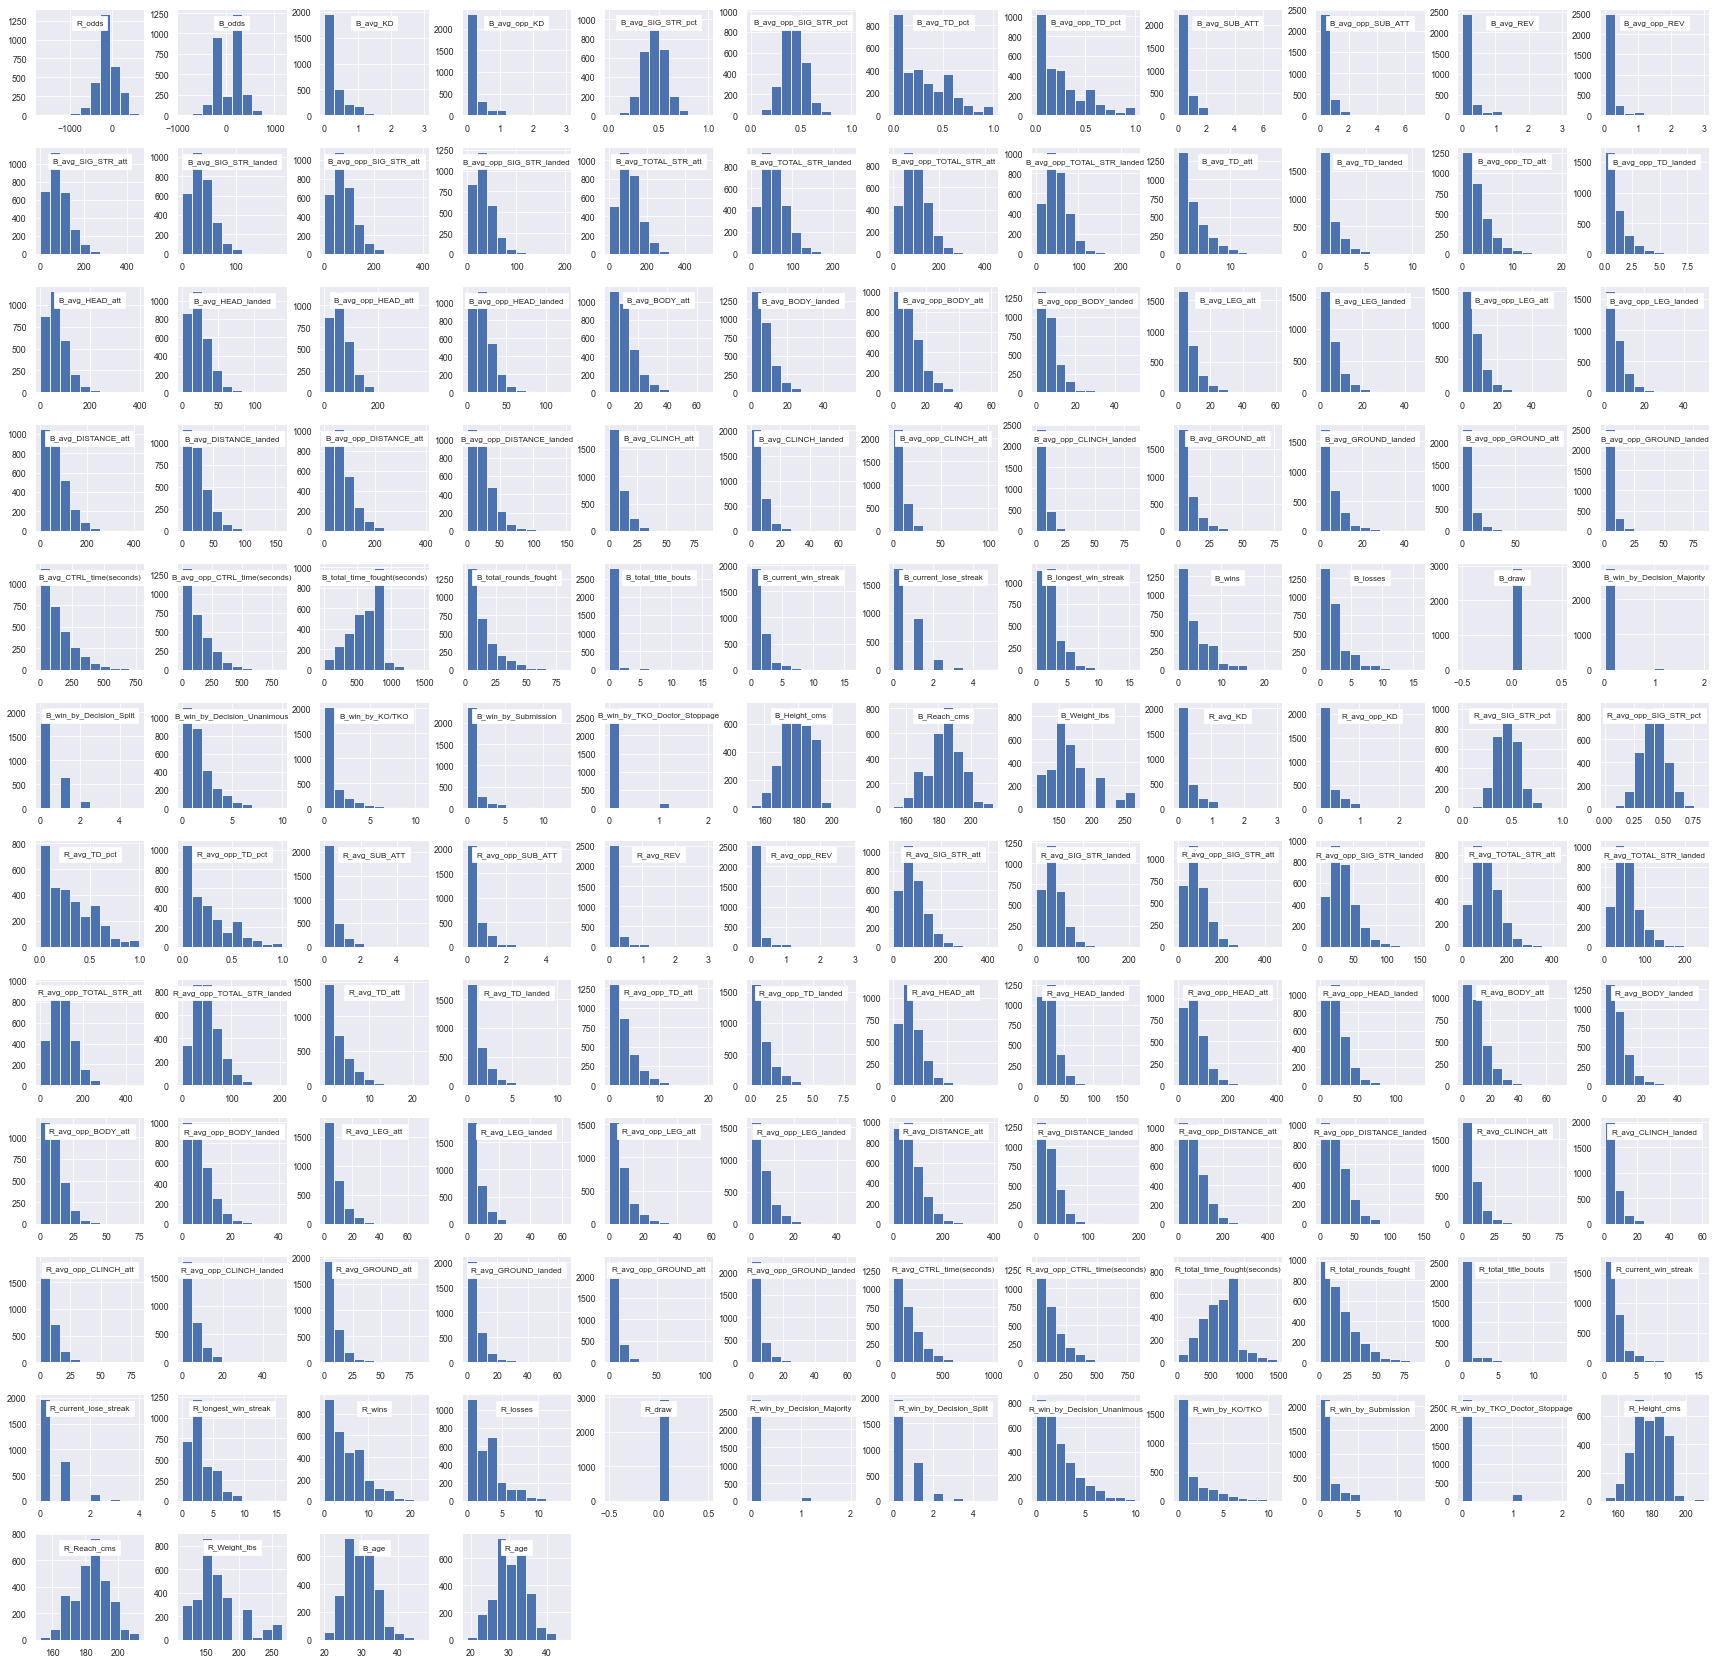

In [819]:
sns.set_context('paper')
#ig,ax = plt.subplots(1,figsize=(10,10))
g = df.hist(figsize=(30,30))

# put titles on plot for clean look
for ax in g.flatten():    
    ax.text(.5,.85,ax.get_title(),
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='white'),
        fontsize=8)
    ax.set_title("")
plt.show()

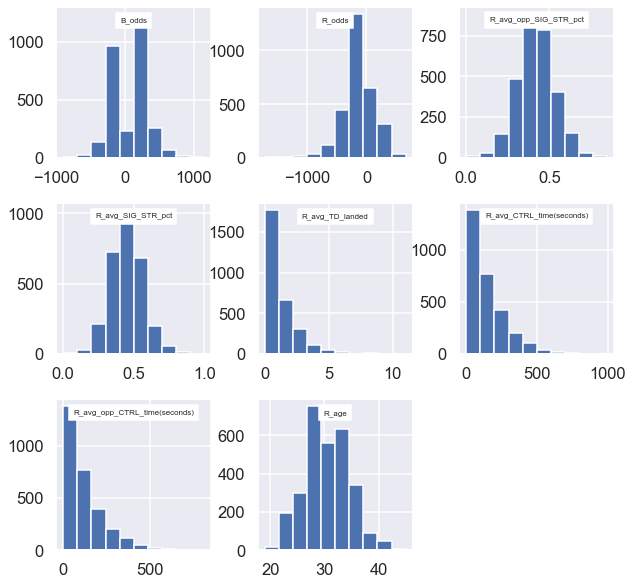

In [816]:
#ig,ax = plt.subplots(1,figsize=(10,10))
g = df_sub.hist(figsize=(10,10))
for ax in g.flatten():
    
    ax.text(.5,.9,ax.get_title(),
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='white'),
        fontsize=8)
    ax.set_title("")
#plt.show()

In [779]:
g
plt.show()

In [747]:
rng = np.random.default_rng()
rng.choice([1,2,3],3)

array([3, 2, 1])

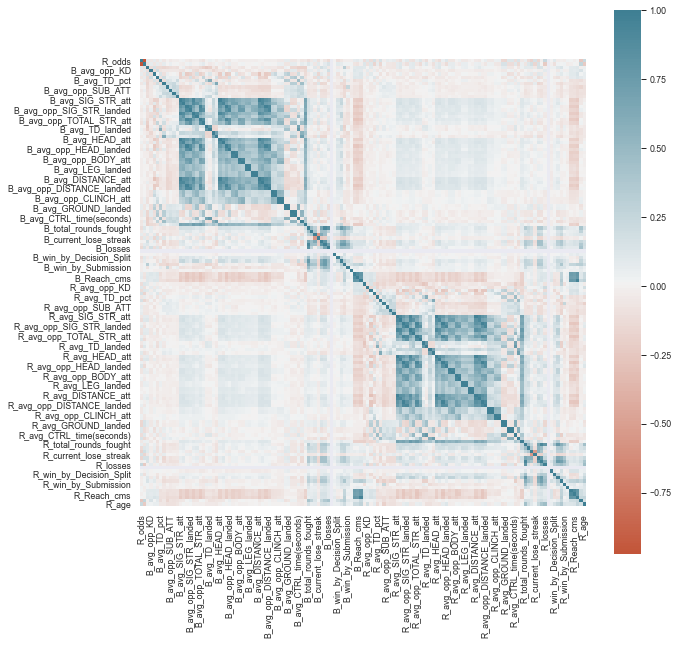

In [820]:
fig,ax = plt.subplots(1, figsize = (10,10))
df_corr = df.drop(columns=['Winner']).corr()
ax = sns.heatmap(df_corr, ax = ax, cmap=sns.diverging_palette(20, 220, n=200), square = True)

In [822]:
R_columns = [col for col in df.columns if 'R_' in col]
R_columns

['R_odds',
 'B_avg_SIG_STR_pct',
 'B_avg_opp_SIG_STR_pct',
 'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed',
 'B_avg_opp_SIG_STR_att',
 'B_avg_opp_SIG_STR_landed',
 'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed',
 'B_avg_opp_TOTAL_STR_att',
 'B_avg_opp_TOTAL_STR_landed',
 'R_avg_KD',
 'R_avg_opp_KD',
 'R_avg_SIG_STR_pct',
 'R_avg_opp_SIG_STR_pct',
 'R_avg_TD_pct',
 'R_avg_opp_TD_pct',
 'R_avg_SUB_ATT',
 'R_avg_opp_SUB_ATT',
 'R_avg_REV',
 'R_avg_opp_REV',
 'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed',
 'R_avg_opp_SIG_STR_att',
 'R_avg_opp_SIG_STR_landed',
 'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed',
 'R_avg_opp_TOTAL_STR_att',
 'R_avg_opp_TOTAL_STR_landed',
 'R_avg_TD_att',
 'R_avg_TD_landed',
 'R_avg_opp_TD_att',
 'R_avg_opp_TD_landed',
 'R_avg_HEAD_att',
 'R_avg_HEAD_landed',
 'R_avg_opp_HEAD_att',
 'R_avg_opp_HEAD_landed',
 'R_avg_BODY_att',
 'R_avg_BODY_landed',
 'R_avg_opp_BODY_att',
 'R_avg_opp_BODY_landed',
 'R_avg_LEG_att',
 'R_avg_LEG_landed',
 'R_avg_opp_LEG_att',
 'R_av

## Train first model: RandomForest

### With PIPE

In [496]:
np.random.seed(404)

cat_features = ['R_Stance','B_Stance','weight_class','gender','title_bout']
cat_transformer = OneHotEncoder(handle_unknown='ignore')
column_trans = make_column_transformer((cat_transformer, cat_features), remainder='passthrough')


X = df.drop(columns=['Winner'])
Y = df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(f"Training size = {X_train.shape[0]}")
print(f"Testing size = {X_test.shape[0]}")



Training size = 2351
Testing size = 588


In [497]:
rf = RandomForestClassifier(random_state = 1)
pipe = make_pipeline(column_trans,rf)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(pipe, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()

print(f'RF K-fold Scores: {np.round(cv_score,3)}')
print(f'RF Average Score: {round(rf_score,3)}')

RF K-fold Scores: [0.636 0.638 0.626 0.604 0.596 0.643 0.655 0.685 0.634 0.698]
RF Average Score: 0.641


In [498]:
X_test.shape

(588, 141)

## some params post pipe

RF Model Accuracy (on testing set): 0.5833


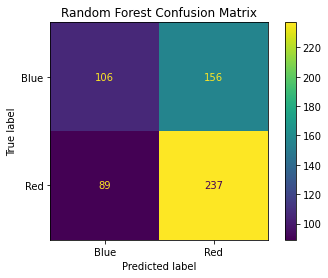

In [501]:
rf_model = pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('RF Confusion Matrix')

print(f'RF Model Accuracy (on testing set): {round(accuracy_score(y_test, y_pred),4)}')

In [520]:
import matplotlib.pyplot as plt


<AxesSubplot:>

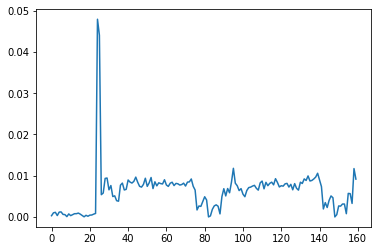

In [519]:
pd.Series(data=importance).plot()

In [564]:
features = pipe.named_steps['columntransformer'].get_feature_names()
importance =  pipe.named_steps['randomforestclassifier'].feature_importances_

feat_importances = pd.Series(importance, index=features)
top_features = feat_importances.nlargest(30)

<AxesSubplot:>

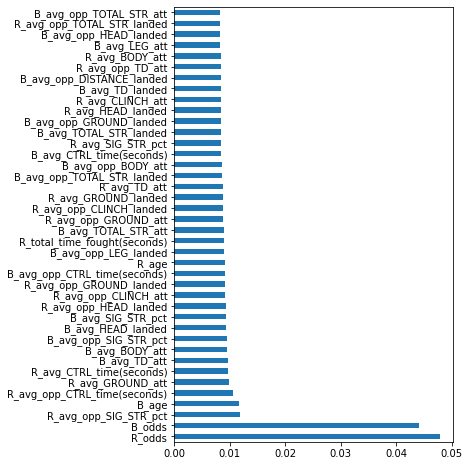

In [576]:
fig,ax = plt.subplots(1,figsize=(5,8))
feat_importances.nlargest(40).plot(ax=ax,kind='barh')


In [789]:
feat_importances.nlargest(40)

R_odds                          0.047929
B_odds                          0.044053
R_avg_opp_SIG_STR_pct           0.011784
B_age                           0.011719
R_avg_opp_CTRL_time(seconds)    0.010587
R_avg_GROUND_att                0.009936
R_avg_CTRL_time(seconds)        0.009667
B_avg_TD_att                    0.009650
B_avg_BODY_att                  0.009556
B_avg_opp_SIG_STR_pct           0.009429
B_avg_HEAD_landed               0.009377
B_avg_SIG_STR_pct               0.009337
R_avg_opp_HEAD_landed           0.009271
R_avg_opp_CLINCH_att            0.009219
R_avg_opp_GROUND_landed         0.009201
B_avg_opp_CTRL_time(seconds)    0.009199
R_age                           0.009162
B_avg_opp_LEG_landed            0.009014
R_total_time_fought(seconds)    0.008950
B_avg_TOTAL_STR_att             0.008949
R_avg_opp_GROUND_att            0.008843
R_avg_opp_CLINCH_landed         0.008841
R_avg_GROUND_landed             0.008711
R_avg_TD_att                    0.008697
B_avg_opp_TOTAL_

## pick better features

In [729]:
df_sub = df[['Winner','B_odds','R_odds','R_avg_opp_SIG_STR_pct','R_avg_SIG_STR_pct','R_avg_TD_landed','R_avg_CTRL_time(seconds)','R_avg_opp_CTRL_time(seconds)','R_age']]
df_sub.reset_index(drop=True,inplace=True)
#df_sub = df[['Winner','B_odds','B_avg_opp_SIG_STR_pct','B_avg_SIG_STR_pct','B_avg_TD_landed','B_avg_CTRL_time(seconds)','B_avg_opp_CTRL_time(seconds)','B_age']]


#df_sub = df[['Winner','R_odds','R_avg_SIG_STR_pct']]

In [680]:
df_sub

,Winner,R_odds,R_avg_opp_SIG_STR_pct,R_avg_SIG_STR_pct,R_avg_TD_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_age
0,Blue,-145.0,0.350507,0.376862,2.273590,243.730927,61.576965,27.0
1,Blue,160.0,0.342987,0.389303,1.045763,167.611663,94.999332,42.0
2,Red,-345.0,0.562344,0.221328,0.226562,13.156250,13.953125,30.0
3,Blue,-137.0,0.460000,0.511250,0.000000,11.500000,11.625000,27.0
4,Red,-160.0,0.369784,0.341092,0.737122,57.932890,130.176998,41.0
...,...,...,...,...,...,...,...,...
2934,Red,-345.0,0.444072,0.321387,0.711914,85.712891,213.166016,34.0
2935,Red,-120.0,0.380605,0.431680,0.048828,19.746094,92.921875,28.0
2936,Red,-420.0,0.339199,0.278574,1.779297,253.279297,58.726562,28.0
2937,Blue,145.0,0.305000,0.317500,0.250000,28.250000,126.500000,29.0


In [678]:
np.random.seed(404)

X = df_sub.drop(columns=['Winner'])
Y = df_sub['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(f"Training size = {X_train.shape[0]}")
print(f"Testing size = {X_test.shape[0]}")

Training size = 2351
Testing size = 588


In [657]:
rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
rf.fit(X_train,y_train)
rf_score = cv_score.mean()
rf_conf_int = 2 * np.std(cv_score)

print(f'RF K-fold Scores: {cv_score:.3f}')
print(f'RF Average Score: {rf_score:.3f} ± {rf_conf_int:.3f}')

RF K-fold Scores: [0.665 0.621 0.609 0.647 0.626 0.655 0.626 0.626 0.664 0.643]
RF Average Score: 0.638 ± 0.037


In [662]:
eli5.show_weights(rf,feature_names=X.columns.values)

Weight,Feature
0.2234 ± 0.0431,R_odds
0.1480 ± 0.0321,R_avg_opp_SIG_STR_pct
0.1418 ± 0.0342,R_avg_opp_CTRL_time(seconds)
0.1388 ± 0.0322,R_avg_CTRL_time(seconds)
0.1346 ± 0.0340,R_avg_SIG_STR_pct
0.1194 ± 0.0299,R_avg_TD_landed
0.0940 ± 0.0245,R_age


Random Forest Model Accuracy (on testing set): 
0.6275510204081632


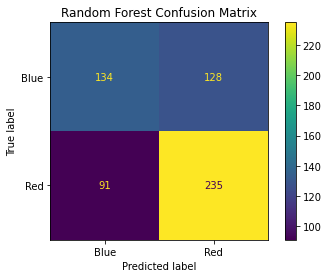

In [628]:
rf = RandomForestClassifier(random_state = 1)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

print('Random Forest Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

### Examples of features impact on individual prediction (local explanation)
This type of analysis helps decision makers trust the model and gives guidance on how to itegrate the models reommendations with other decision factors. It could even help individual fighters decide where to focus their training (e.g. if Signficiant Stikes increasing win probablity greatly over submission)

In [698]:
weights = eli5.show_prediction(rf, X_test.iloc[4], feature_names=X.columns.values, show_feature_values=True)
#weights.data = weights.data.replace('background-color','color:black; backround-color')
weights

In [700]:
weights = eli5.show_prediction(rf, X_test.iloc[3], feature_names=X.columns.values, show_feature_values=True)
#weights.data = weights.data.replace('background-color','color:black; backround-color')
weights

Predicted Red corner would win, despite being the underdog, R_odds 210, which had a negative weight on the predicition (-0.163). The most positively weighted feature (R_avg_opp_SIG_STR_pct)  

In [702]:
weights = eli5.show_prediction(rf, X_test.iloc[2], feature_names=X.columns.values, show_feature_values=True)
#weights.data = weights.data.replace('background-color','color:black; backround-color')
weights

In [704]:
weights = eli5.show_prediction(rf, X_test.iloc[0], feature_names=X.columns.values, show_feature_values=True)
#weights.data = weights.data.replace('background-color','color:black; backround-color')
weights

In [705]:
weights = eli5.show_prediction(rf, X_test.iloc[100], feature_names=X.columns.values, show_feature_values=True)
#weights.data = weights.data.replace('background-color','color:black; backround-color')
weights

## Global explainability

In [854]:
shap.initjs()

In [878]:
import shap
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_train = explainerRF.shap_values(X_train)
shap_values_RF_test = explainerRF.shap_values(X_test)


#df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
#df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)

# not supported by the libary it seems
shap_values_RF_train = explainerRF.shap_values(X_train,y_train.astype("category").cat.codes)
shap_values_RF_test = explainerRF.shap_values(X_test,y_test.astype("category").cat.codes)

In [891]:
explainerRF.shap_interaction_values(X_train)

[array([[[ 7.79929608e-02, -3.87205802e-02, -7.30192247e-03, ...,
          -1.28367324e-02, -1.94705848e-03, -1.21505245e-02],
         [-3.87205802e-02,  7.21335733e-02, -1.25812314e-02, ...,
          -1.64861890e-02, -1.24602207e-02, -1.17372932e-02],
         [-7.30192247e-03, -1.25812314e-02,  3.75495282e-02, ...,
          -9.51058244e-04, -1.90546421e-02, -7.60823265e-03],
         ...,
         [-1.28367324e-02, -1.64861890e-02, -9.51058244e-04, ...,
           2.46934602e-02, -8.18693858e-03, -8.56211097e-03],
         [-1.94705848e-03, -1.24602207e-02, -1.90546421e-02, ...,
          -8.18693858e-03,  7.46519060e-03, -7.81723485e-03],
         [-1.21505245e-02, -1.17372932e-02, -7.60823265e-03, ...,
          -8.56211097e-03, -7.81723485e-03, -6.07387037e-03]],
 
        [[ 1.07052262e-02,  5.93894059e-04,  1.43585176e-02, ...,
           1.26547190e-02,  7.52240482e-03,  9.86390282e-03],
         [ 5.93894059e-04, -5.86331108e-03,  1.55004034e-02, ...,
           1.42431219

In [889]:
row = 0
shap.force_plot(explainerRF.expected_value[0], shap_values_RF_test[0][row], X_test.iloc[[row]])

In [880]:
row = 0
shap.force_plot(explainerRF.expected_value[0], shap_values_RF_test[0][row], X_test.iloc[[row]])

In [859]:
shap.force_plot(explainerRF.expected_value[1], shap_values_RF_test[1][row], X_test.iloc[[row]])

In [895]:
# visualize all the training set predictions
shap.plots.force(explainerRF.expected_value[1],shap_values_RF_test[1])

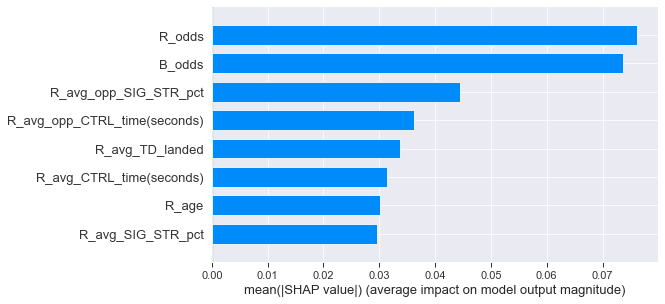

In [896]:
shap.summary_plot(shap_values_RF_train[1], X_train, plot_type="bar")


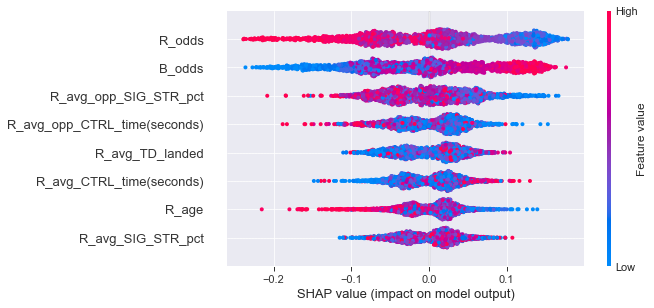

In [897]:
shap.summary_plot(shap_values_RF_train[1], X_train)


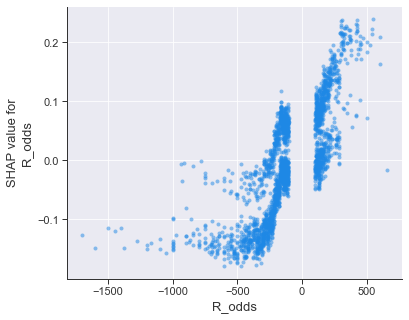

In [872]:
## variable influence/ dependence plots aide model interpretability. A richer extension of partial depenence plots from the SHAP library. Vertical spread represents interaction effects. 

shp_plt = shap.dependence_plot("R_odds", shap_values_RF_train[0], X_train,interaction_index = None,alpha=.5)


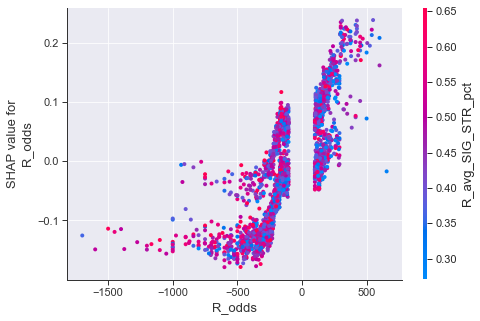

In [877]:
shp_plt = shap.dependence_plot("R_odds", shap_values_RF_train[0], X_train,interaction_index = 'auto')


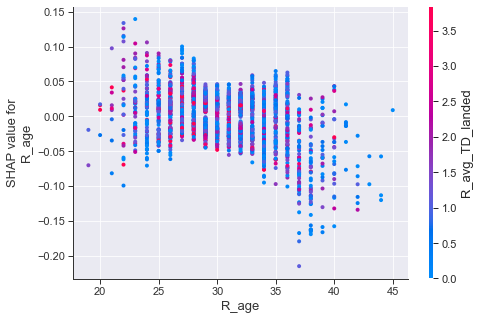

In [902]:
shp_plt = shap.dependence_plot("R_age", shap_values_RF_train[1], X_train,interaction_index = 'R_avg_TD_landed')


In [ ]:
shp_plt = shap.dependence_plot("R_age", shap_values_RF_train[0], X_train)


## grid search

In [395]:
from sklearn.model_selection import GridSearchCV


parameters = [{'criterion':['gini', 'entropy'],
               'max_depth':[2, 3,4,5],
               'max_features': [2, 3, 4, 5],
               'n_estimators': [100, 200, 300, 1000]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)


grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, cv = kfold, n_jobs=-1)
grid.fit(X_train, y_train)



rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], criterion = grid.best_params_['criterion'], max_depth = grid.best_params_['max_depth'])
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()

print(f'RF K-fold Scores: {np.round(cv_score,3)}')
print(f'RF Average Score: {round(rf_score,3)}')

Random Forest K-fold Scores:
[0.64705882 0.6199095  0.62895928 0.6199095  0.63181818 0.59545455
 0.64545455 0.57727273 0.58181818 0.62727273]

Random Forest Average Score:
0.6174928013163308


## Grid search df_sub

In [629]:


parameters = [{'criterion':['gini', 'entropy'],
               'max_depth':[2, 3,4,5],
               'max_features': [2, 3, 4, 5],
               'n_estimators': [100, 200, 300, 1000]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)


grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, cv = kfold, n_jobs=-1)
grid.fit(X_train, y_train)



rf_grid = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], criterion = grid.best_params_['criterion'], max_depth = grid.best_params_['max_depth'])
cv_score = cross_val_score(rf_grid, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()

print(f'RF K-fold Scores: {np.round(cv_score,3)}')
print(f'RF Average Score: {round(rf_score,3)}')

Random Forest K-fold Scores:
[0.67372881 0.62978723 0.60851064 0.62978723 0.63404255 0.65531915
 0.61702128 0.67659574 0.6        0.63404255]

Random Forest Average Score:
0.6358835196538044


Random Forest Model Accuracy (on testing set): 
0.6156462585034014


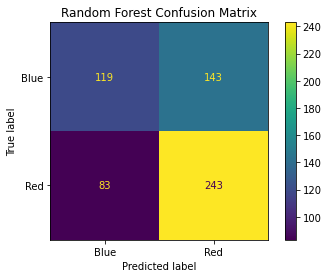

In [630]:
rf_model = rf_grid.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

print('Random Forest Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

## No bets

In [264]:
X = df.drop(columns=['B_odds','R_odds','Winner'])
Y = df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()

print(f'RF K-fold Scores: {np.round(cv_score,3)}')
print(f'RF Average Score: {round(rf_score,3)}')

Random Forest K-fold Scores:
[0.58823529 0.58823529 0.56108597 0.59276018 0.61363636 0.57727273
 0.61363636 0.55       0.61363636 0.59545455]

Random Forest Average Score:
0.5893953105717811


## Only bets

In [240]:
X = df[["R_odds","B_odds"]]
Y = df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()
print('Random Forest K-fold Scores:')
print(cv_score)
print()
print('Random Forest Average Score:')
print(rf_score)

Random Forest K-fold Scores:
[0.61538462 0.58823529 0.59276018 0.63348416 0.60454545 0.64545455
 0.62727273 0.57272727 0.59090909 0.64545455]

Random Forest Average Score:
0.6116227889757302


## Big 

In [641]:

bets=[100,150,200,250,300,350]
avg_scores=[]

for bet in bets:
    df_fav = df_sub.query('R_odds > @bet or R_odds < -@bet')

    #X = df_fav[["R_odds","B_odds"]]
    X = df_fav.drop(columns=["Winner"])
    Y = df_fav['Winner']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)



    rf = RandomForestClassifier(random_state = 1)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
    avg_scores.append(cv_score.mean())


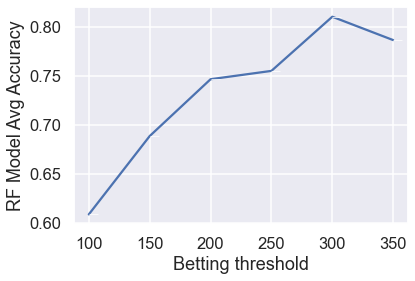

In [812]:
sns.set_theme()
sns.set_context("talk")

ax = sns.lineplot(x=bets,y=avg_scores,marker=True)
ax.set(xlabel='Betting threshold',
       ylabel='RF Model Avg Accuracy')
plt.show()

## XGBoost

In [722]:
X = df_sub.drop(columns=['Winner'])
Y = df_sub['Winner']

# this alog needs the 
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.20, random_state=42)
print(f"Training size = {X_train.shape[0]}")
print(f"Testing size = {X_test.shape[0]}")

xgb = XGBClassifier(objective='binary:logistic',random_state =1, use_label_encoder=False, eval_metric = 'logloss')
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
xgb_cv_scores = cross_val_score(xgb, X_train, y_train, cv=kfold)
xgb_score = xgb_cv_scores.mean()
print(f'XGBoost Classifier K-fold Scores: {np.round(xgb_cv_scores,3)}')
print(f'XGBoost Classifier Average Score: {round(xgb_score,3)}')

Training size = 2351
Testing size = 588
XGBoost Classifier K-fold Scores: [0.674 0.609 0.579 0.609 0.613 0.604 0.591 0.57  0.604 0.579]
XGBoost Classifier Average Score: 0.603


## LogisticRegression

In [723]:
lr = LogisticRegression(max_iter = 10000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)
lr_score = cv_score.mean()
print(f'LR kfold scores: {np.round(cv_score,3)}')
print(f'LR avg score: {round(lr_score,3)}')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Gaussian Naive Bayes

In [279]:


gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=kfold)
gnb_score = cv_score.mean()
print(f'Gaussian Naive Bayes K-fold Scores: {np.round(cv_score,3)}')
print(f'Gaussian Naive Bayes Average Score: {round(gnb_score,3)}')

Gaussian Naive Bayes K-fold Scores: [0.602 0.502 0.561 0.507 0.582 0.568 0.564 0.559 0.577 0.595]
Gaussian Naive Bayes Average Score: 0.562


## Correlation

"\nax.set_xticklabels(\n    ax.get_xticklabels(),\n    rotation=45,\n    horizontalalignment='right'\n);\n\n"

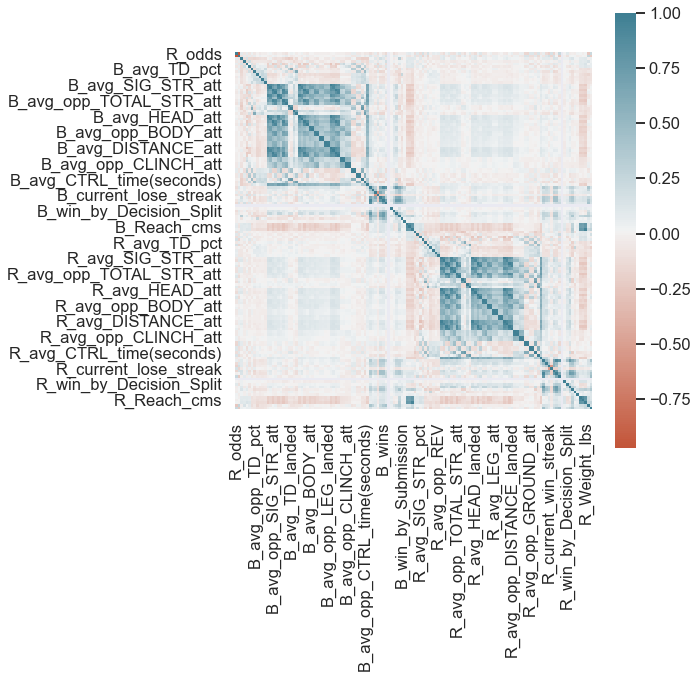

NameError: name 'cor' is not defined

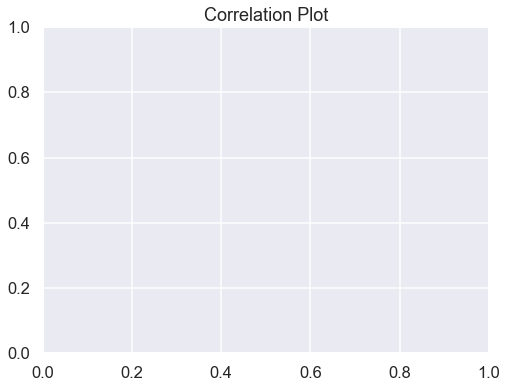

In [813]:


fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Dimension reduction

In [400]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.decomposition import PCA

In [401]:
import umap

In [414]:
x = df.drop(columns=['Winner'])
x = StandardScaler().fit_transform(x)
y = Y


pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3'])
principal.shape

(2939, 3)

Text(0, 0.5, 'Principal Component 2')

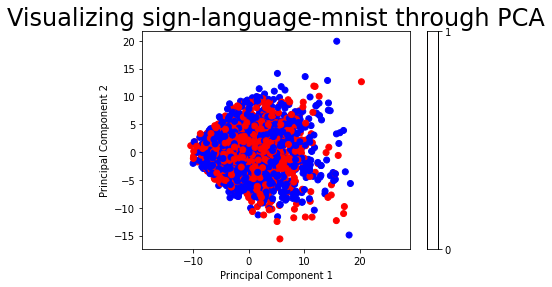

In [421]:
# Plotting PCA 2Dplt.style.use('dark_background')
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=Y, cmap='bwr')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(2)).set_ticks(np.arange(2))
plt.title('Visualizing sign-language-mnist through PCA', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

<ipython-input-431-d49707ffe485>:1: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



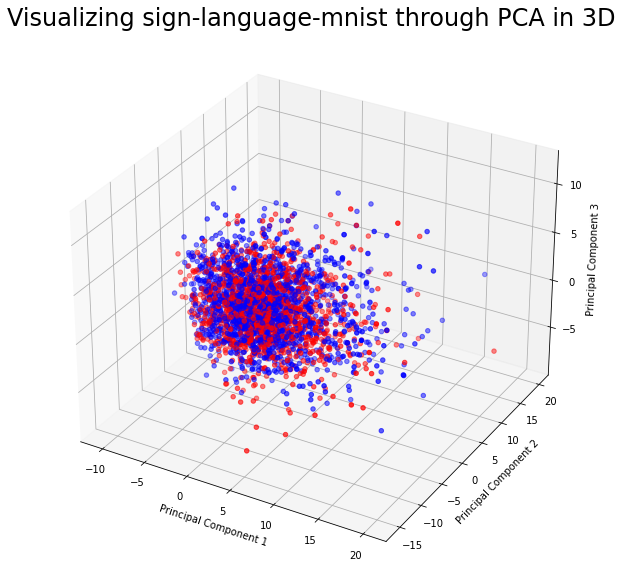

In [431]:
ax = plt.figure(figsize=(12,10)).gca(projection='3d')
ax.scatter(
    xs=principalComponents[:, 0], 
    ys=principalComponents[:, 1], 
    zs=principalComponents[:, 2], 
    c=Y, 
    cmap='bwr'
)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Visualizing sign-language-mnist through PCA in 3D', fontsize=24);
plt.show()

In [427]:
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

In [448]:
def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_dark'
    fig.write_html('first_figure.html', auto_open=True)
    #fig.show()
    
    

def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    #fig.write_html('first_figure.html', auto_open=True)
    #fig.show()
    fig

In [449]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])

ImportError: Please install ipywidgets>=7.0.0 to use the FigureWidget class

In [439]:
# example
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.write_html('first_figure.html', auto_open=True)

In [440]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])

In [450]:
!pip install ipywidgets


  Using cached ipywidgets-7.6.3-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.0-py3-none-any.whl (243 kB)
  Using cached widgetsnbextension-3.5.1-py2.py3-none-any.whl (2.2 MB)


## umap

In [444]:
import time
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=2)
embedding = reducer.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 9.920235395431519 seconds


In [446]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])

In [ ]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])